In [486]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

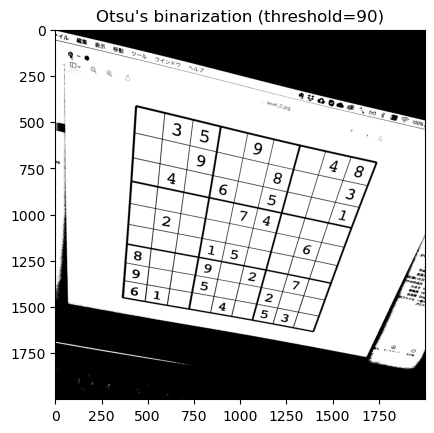

In [487]:
image = cv2.imread("./data/level_2.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# ぼかし処理
gray_gb = cv2.GaussianBlur(gray, None, 3.0)

# 大津の二値化
thr, binary = cv2.threshold(gray_gb, 0, 255, cv2.THRESH_OTSU)
new_thr = min(int(thr * 1.3), 255)
_, binary = cv2.threshold(gray, new_thr, 255, cv2.THRESH_BINARY)
plt.imshow(binary, cmap="gray")
plt.title("Otsu's binarization (threshold={:d})".format(int(thr)))
plt.show()

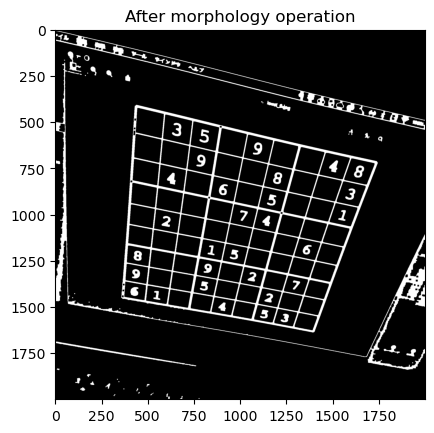

In [488]:
edge = cv2.Canny(binary, 100, 200)
edge = cv2.dilate(edge, np.ones((11, 11), dtype=edge.dtype))
edge = cv2.erode(edge, np.ones((9, 9), dtype=edge.dtype))
# res_close = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 5), dtype=binary.dtype))
plt.imshow(edge, cmap="gray")
plt.title("After morphology operation".format(thr))
plt.show()

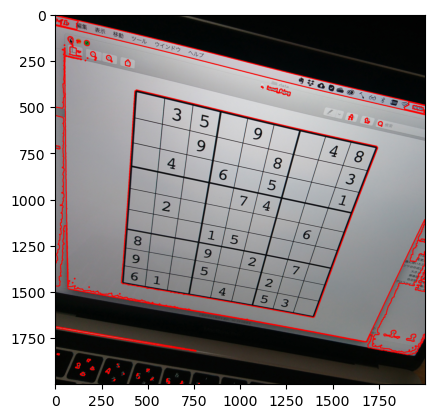

In [489]:
contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
result = image.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.show()

1811


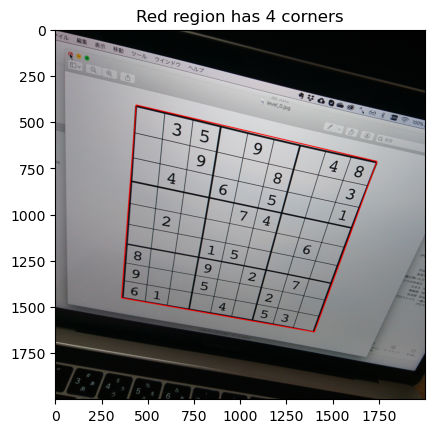

In [490]:
longest_cnt = None
max_length = 0.0
for cnt in contours:
    # 輪郭線の長さを計算
    arclen = cv2.arcLength(cnt, True)
    approx=cv2.approxPolyDP(cnt, arclen * 1.0e-1, True)
    if max_length < arclen and len(approx) == 4:
        max_length = arclen
        longest_cnt = cnt
result = image.copy()
# cv2.drawContours(result, [longest_cnt], -1, (255, 0, 0), 3, cv2.LINE_AA)
# plt.imshow(result)
# plt.show()
print(len(longest_cnt))
arclen = cv2.arcLength(longest_cnt, True)
approx = cv2.approxPolyDP(longest_cnt, arclen * 1.0e-1, True)

result = image.copy()
cv2.drawContours(result, [approx], -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.title("Red region has {:d} corners".format(len(approx)))
plt.show()
# len(contours[0])

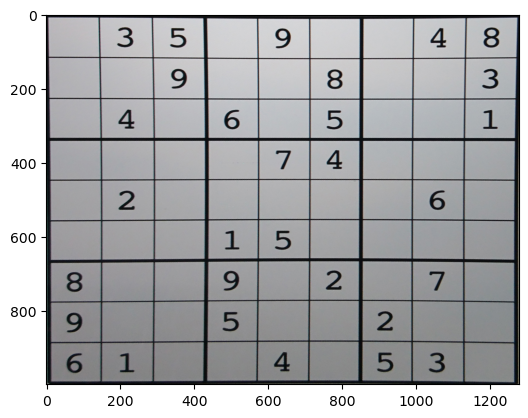

In [491]:
x, y, w, h = cv2.boundingRect(approx)
src_pts = approx.reshape((-1, 2)).astype("float32")

# 縦横比の計算
w = np.linalg.norm(src_pts[3] - src_pts[0])
h = np.linalg.norm(src_pts[1] - src_pts[0])
aspect = abs(w) / abs(h)

# 新しい画像サイズを設定
new_w = int(1000 * aspect)
new_h = 1000
dst_pts = np.array([(0, 0), (0, new_h), (new_w, new_h), (new_w, 0)], dtype="float32")

# 射影変換を計算して、パースをキャンセルする
warp = cv2.getPerspectiveTransform(src_pts, dst_pts)
result = cv2.warpPerspective(image, warp, (new_w, new_h))
# result = cv2.warpPerspective(binary, warp, (new_w, new_h))
plt.imshow(result)
# plt.imshow(result, cmap="gray")

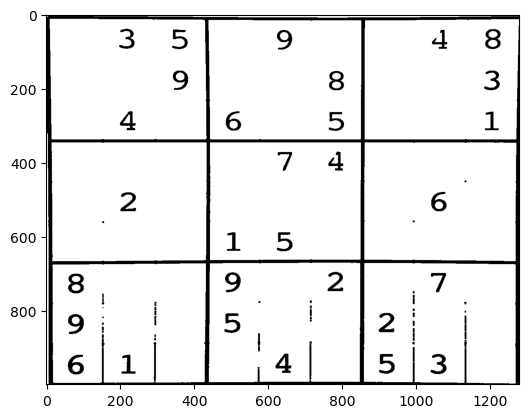

In [492]:
# 内側の細い線を塗りつぶす
# closing
image_closed = cv2.dilate(result, np.ones((2, 2), dtype=edge.dtype),iterations=4)
image_closed = cv2.erode(image_closed, np.ones((2, 2), dtype=edge.dtype),iterations=4)
# opening
# tmp = cv2.erode(cropped_region, np.ones((1, 1), dtype=edge.dtype),iterations=2)
# tmp = cv2.dilate(tmp, np.ones((1, 1), dtype=edge.dtype))

# plt.imshow(image_cl,cmap="gray")

    # 画像から領域を切り出す
cropped_region = image_closed

plt.imshow(cropped_region,cmap="gray")
cropped_region_gr=cv2.cvtColor(cropped_region, cv2.COLOR_RGB2GRAY)
thr, binary = cv2.threshold(cropped_region_gr, 0, 255, cv2.THRESH_OTSU)
plt.imshow(binary, cmap="gray")
# cropped_region.shape

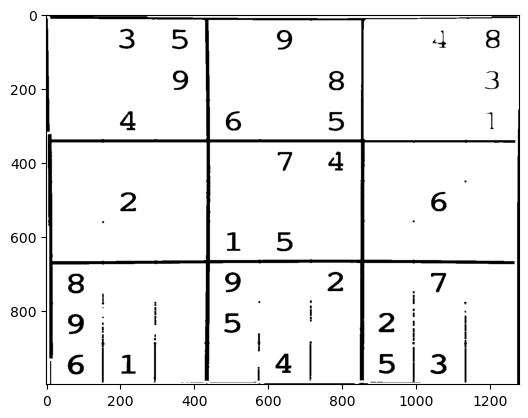

In [493]:
# contoursを黒で塗りつぶす
edge = cv2.Canny(binary, 100, 200)
edge = cv2.dilate(edge, np.ones((11, 11), dtype=edge.dtype))
edge = cv2.erode(edge, np.ones((9, 9), dtype=edge.dtype))
contours, hierarchy= cv2.findContours(edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
draws=[]
for i,contour in enumerate(contours):
    #親のindexが1以下のものをつぶす
    if hierarchy[0,i][3]<=1:
        draws.append(contour)

cv2.drawContours(binary, draws, -1, (255,255,255), 5, cv2.FILLED)
plt.imshow(binary,cmap="gray")
plt.show()
height, width, _ = cropped_region.shape

# トリミングする範囲を計算
trim_percentage = 0.005  # 外側を1%トリミング
trim_width = int(width * trim_percentage)
trim_height = int(height * trim_percentage)
cropped_region = cropped_region[trim_height:height-trim_height, trim_width:width-trim_width]

(360, 360)

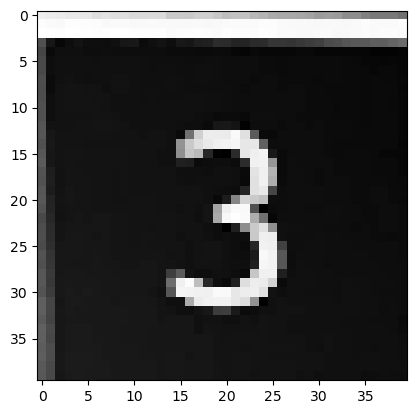

In [494]:
pixel=40
# 大津の二値化
cropped_region_gr=cv2.cvtColor(cropped_region, cv2.COLOR_RGB2GRAY)
thr, binary = cv2.threshold(cropped_region_gr, 0, 255, cv2.THRESH_OTSU)
plt.imshow(binary, cmap="gray")
cropped_rs = cv2.resize(cropped_region_gr, (pixel*9,pixel*9), interpolation=cv2.INTER_CUBIC)
# cropped_region=cv2.cvtColor(cropped_rs, cv2.COLOR_RGB2GRAY)
cropped_rs=cv2.bitwise_not(cropped_rs)

i,j=0,1
plt.imshow(cropped_rs[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel], cmap='gray')
# plt.imshow(cropped_rs, cmap='gray')
cropped_rs.shape

In [495]:
scaler = pd.read_pickle('./pickle/rf_scaler.pickle')
clf=pd.read_pickle('./pickle/rf_clf.pickle')
pixel=40

predicted_digits = []
# cropped_region_rs = cv2.resize(cropped_region_gr, (pixel*9,pixel*9),interpolation=cv2.INTER_AREA)
# cropped_region_rs = cv2.resize(cropped_region, (pixel*9,pixel*9),interpolation=cv2.INTER_CUBIC)
# cropped_region_=cropped_region_rs.copy()
# cropped_region_rs=cv2.cvtColor(cropped_region_rs, cv2.COLOR_RGB2GRAY)
# cropped_region_rs=cv2.bitwise_not(cropped_region_rs)
for i in range(9):
    for j in range(9):
        digit_square = cropped_rs[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel]
        # plt.imshow(cropped_region_[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel])
        if np.mean(digit_square)<=10:
            predicted_digits.append(0)
            continue
        digit_square = digit_square.reshape(1, -1)/255.0
        digit_square=scaler.transform(digit_square)

        # print(digit_square.shape)
        # digit_square = np.expand_dims(digit_square, axis=0)
        # print(digit_square.shape)
        prediction = clf.predict(digit_square)
        predicted_digit = np.argmax(prediction)
        predicted_digits.append(prediction[0])
problem=[]
for i in range(0, len(predicted_digits), 9):
    problem.append(predicted_digits[i:i+9])
    print(predicted_digits[i:i+9])

[8, 8, 8, 8, 8, 8, 8, 6, 8]
[8, 8, 8, 8, 8, 8, 8, 8, 8]
[8, 8, 8, 8, 8, 8, 8, 8, 8]
[8, 8, 8, 8, 8, 6, 8, 8, 8]
[8, 8, 8, 8, 8, 8, 8, 6, 8]
[6, 8, 8, 8, 6, 8, 8, 8, 8]
[6, 6, 6, 6, 6, 6, 6, 8, 8]
[6, 8, 6, 6, 6, 8, 8, 6, 8]
[6, 8, 8, 8, 6, 8, 8, 8, 8]


In [496]:
matrix_data = [ [0, 3, 5, 0, 9, 0, 0, 4, 8],
                [0, 0, 9, 0, 0, 8, 0, 0, 3],
                [0, 4, 0, 6, 0, 5, 0, 0, 1],
                [0, 0, 0, 0, 7, 4, 0, 0, 0],
                [0, 2, 0, 0, 0, 0, 0, 6, 0],
                [0, 0, 0, 1, 5, 0, 0, 0, 0],
                [8, 0, 0, 9, 0, 2, 0, 7, 0],
                [9, 0, 0, 5, 0, 0, 2, 0, 0],
                [6, 1, 0, 0, 4, 0, 5, 3, 0]]
oks=[matrix_data[i][j]==problem[i][j] for i in range(9) for j in range(9)]
print(sum(oks)/len(oks))


0.04938271604938271
